In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q opencv-python-headless scipy scikit-learn tqdm

In [34]:
#Set Paths for Part-B
DATA_ROOT = "/content/drive/MyDrive/ShanghaiTech"

IMG_DIR = f"{DATA_ROOT}/part_B/train_data/images"
GT_DIR  = f"{DATA_ROOT}/part_B/train_data/ground-truth"

SAVE_IMG = f"{IMG_DIR}/images_prepro"
os.makedirs(SAVE_IMG, exist_ok=True)

print("IMG_DIR =", IMG_DIR)
print("GT_DIR  =", GT_DIR)
print("SAVE_IMG =", SAVE_IMG)

IMG_DIR = /content/drive/MyDrive/ShanghaiTech/part_B/train_data/images
GT_DIR  = /content/drive/MyDrive/ShanghaiTech/part_B/train_data/ground-truth
SAVE_IMG = /content/drive/MyDrive/ShanghaiTech/part_B/train_data/images/images_prepro


In [10]:
import cv2
import numpy as np
import torch
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

RESIZE_TO = (512, 512)

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

def preprocess_partB():
    print("📌 Processing Part-B...")

    for img_name in tqdm(os.listdir(IMG_DIR)):
        if not img_name.endswith(".jpg"):
            continue

        img_path = os.path.join(IMG_DIR, img_name)
        gt_path = os.path.join(GT_DIR, "GT_" + img_name.replace(".jpg", ".mat"))

        # Load image
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0
        H0, W0 = img.shape[:2]

        # Load annotations
        mat = loadmat(gt_path)
        points = mat["image_info"][0][0][0][0][0]

        # Resize image
        img_resized = cv2.resize(img, RESIZE_TO)

        # Scale points
        scale_x = RESIZE_TO[0] / W0
        scale_y = RESIZE_TO[1] / H0

        scaled_points = np.zeros((len(points), 2))
        for i, (x, y) in enumerate(points):
            scaled_points[i] = [int(x * scale_x), int(y * scale_y)]

        # Density map
        density = np.zeros(RESIZE_TO, dtype=np.float32)
        for x, y in scaled_points:
            if 0 <= x < RESIZE_TO[0] and 0 <= y < RESIZE_TO[1]:
                density[y, x] = 1

        density = gaussian_filter(density, sigma=3)

        # Downsample 8×
        h8, w8 = RESIZE_TO[1] // 8, RESIZE_TO[0] // 8
        density_8 = cv2.resize(density, (w8, h8))
        density_8 *= 64

        # Normalize image (ImageNet)
        img_norm = (img_resized - mean) / std

        # Convert to tensors
        img_tensor = torch.from_numpy(img_norm).permute(2, 0, 1)
        gt_tensor  = torch.from_numpy(density_8).unsqueeze(0)

        # Save .pt
        save_path = os.path.join(SAVE_IMG, img_name.replace(".jpg", ".pt"))
        torch.save({"image": img_tensor, "gt": gt_tensor}, save_path)

    print("✔ Part-B Preprocessing Completed")

In [11]:
files = [f for f in os.listdir(SAVE_IMG) if f.endswith(".pt")]
print("Total preprocessed Part-B samples:", len(files))

Total preprocessed Part-B samples: 400


In [12]:
from torch.utils.data import Dataset, DataLoader

class CrowdDataset(Dataset):
    def __init__(self, path):
        self.files = sorted([
            os.path.join(path, f)
            for f in os.listdir(path) if f.endswith(".pt")
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        return data["image"], data["gt"]

dataset = CrowdDataset(SAVE_IMG)
DATALOADER = DataLoader(dataset, batch_size=2, shuffle=True)

print("Total samples:", len(dataset))

Total samples: 400


In [15]:
# ====== CSRNet Model Definition ======
import torch
import torch.nn as nn
import torchvision.models as models

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        # FRONTEND = VGG-16 (first 13 layers)
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])

        # BACKEND = Dilated Convolutions
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU()
        )

        # DENSITY MAP OUTPUT
        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

# Instantiate model
model = CSRNet()
print("CSRNet model created")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 147MB/s]


CSRNet model created


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)

Using device: cuda


In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [19]:
#dataset loader
class CrowdDataset(Dataset):
    def __init__(self, path):
        self.files = sorted([
            os.path.join(path, f)
            for f in os.listdir(path) if f.endswith(".pt")
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])

        img = data["image"].float()      # <<< FIX: convert to float32
        gt  = data["gt"].float()         # <<< FIX: convert to float32

        return img, gt

In [23]:
#preprocessing
RESIZE_TO = (512, 512)
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

def preprocess_partB():
    print("📌 Starting Preprocessing Part-B...")

    for img_name in tqdm(os.listdir(IMG_DIR)):
        if not img_name.endswith(".jpg"):
            continue

        img_path = os.path.join(IMG_DIR, img_name)
        gt_path = os.path.join(GT_DIR, "GT_" + img_name.replace(".jpg", ".mat"))

        # Load image
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0
        H0, W0 = img.shape[:2]

        # Load annotation for Part-B
        mat = loadmat(gt_path)
        points = mat["image_info"][0][0][0][0][0]

        # Resize image
        img_resized = cv2.resize(img, RESIZE_TO)

        # Scale points
        scale_x = RESIZE_TO[0] / W0
        scale_y = RESIZE_TO[1] / H0

        scaled = []
        for x, y in points:
            scaled.append([int(x * scale_x), int(y * scale_y)])

        # Density map
        density = np.zeros(RESIZE_TO, dtype=np.float32)
        for x, y in scaled:
            if 0 <= x < RESIZE_TO[0] and 0 <= y < RESIZE_TO[1]:
                density[y, x] = 1

        density = gaussian_filter(density, sigma=3)

        # Downsample ×8
        h8 = RESIZE_TO[1] // 8
        w8 = RESIZE_TO[0] // 8
        density_8 = cv2.resize(density, (w8, h8))
        density_8 *= 64

        # Normalize image
        img_norm = (img_resized - mean) / std

        # Convert to float32 tensors
        img_tensor = torch.from_numpy(img_norm).permute(2, 0, 1).float()
        gt_tensor  = torch.from_numpy(density_8).unsqueeze(0).float()

        # Save
        save_path = os.path.join(SAVE_IMG, img_name.replace(".jpg", ".pt"))
        torch.save({"image": img_tensor, "gt": gt_tensor}, save_path)

    print("✔ Done Preprocessing Part-B")

In [24]:
preprocess_partB()

files = [f for f in os.listdir(SAVE_IMG) if f.endswith(".pt")]
print("Total preprocessed:", len(files))

📌 Starting Preprocessing Part-B...


100%|██████████| 401/401 [12:38<00:00,  1.89s/it]

✔ Done Preprocessing Part-B
Total preprocessed: 400


In [25]:
#dataset loader
class CrowdDataset(Dataset):
    def __init__(self, root):
        self.files = sorted([os.path.join(root, f) for f in os.listdir(root) if f.endswith(".pt")])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        img = data["image"].float()
        gt  = data["gt"].float()
        return img, gt

dataset = CrowdDataset(SAVE_IMG)
DATALOADER = DataLoader(dataset, batch_size=2, shuffle=True)

print("Total samples in DataLoader:", len(dataset))

Total samples in DataLoader: 400


In [26]:
#CSRNet Model
import torchvision.models as models

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2), nn.ReLU()
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

model = CSRNet()
print("CSRNet model loaded.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CSRNet model loaded.


In [27]:
#device+loss+optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

Using device: cuda


In [35]:
#training
epochs = 5
epoch_losses = []

for ep in range(epochs):
    model.train()
    total_loss = 0
    print(f"\nEPOCH {ep+1}/{epochs}")

    for img, gt in tqdm(DATALOADER, desc=f"Epoch {ep+1}", ncols=80):
        img, gt = img.to(device), gt.to(device)

        pred = model(img)
        loss = criterion(pred, gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item())

    avg_loss = total_loss / len(DATALOADER)
    epoch_losses.append(avg_loss)

    print(f"Epoch {ep+1} Loss: {avg_loss:.6f}")


EPOCH 1/5


Epoch 1: 100%|████████████████████████████████| 200/200 [00:55<00:00,  3.63it/s]


Epoch 1 Loss: 0.011568

EPOCH 2/5


Epoch 2: 100%|████████████████████████████████| 200/200 [00:56<00:00,  3.54it/s]


Epoch 2 Loss: 0.010910

EPOCH 3/5


Epoch 3: 100%|████████████████████████████████| 200/200 [00:58<00:00,  3.41it/s]


Epoch 3 Loss: 0.010558

EPOCH 4/5


Epoch 4: 100%|████████████████████████████████| 200/200 [00:57<00:00,  3.46it/s]


Epoch 4 Loss: 0.009522

EPOCH 5/5


Epoch 5: 100%|████████████████████████████████| 200/200 [00:56<00:00,  3.52it/s]

Epoch 5 Loss: 0.008856


In [29]:
#create validation split (20%)
from sklearn.model_selection import train_test_split

all_files = sorted([os.path.join(SAVE_IMG, f) for f in os.listdir(SAVE_IMG) if f.endswith(".pt")])

train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

print("Train samples:", len(train_files))
print("Validation samples:", len(val_files))

Train samples: 320
Validation samples: 80


In [30]:
#validation datset+dataloader
class CrowdDatasetFromList(Dataset):
    def __init__(self, file_list):
        self.files = file_list

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        img = data["image"].float()
        gt  = data["gt"].float()
        return img, gt

val_dataset = CrowdDatasetFromList(val_files)
VAL_LOADER = DataLoader(val_dataset, batch_size=1, shuffle=False)

print("Validation loader ready.")

Validation loader ready.


In [36]:
#validation function (MAE,RMSE)
def validate(model, loader):
    model.eval()
    mae = 0.0
    mse = 0.0

    with torch.no_grad():
        for img, gt in tqdm(loader, desc="Validating", ncols=80):
            img, gt = img.to(device), gt.to(device)

            pred = model(img)

            # Sum of density map = predicted count
            gt_count = gt.sum().item()
            pred_count = pred.sum().item()

            mae += abs(gt_count - pred_count)
            mse += (gt_count - pred_count) ** 2

    mae /= len(loader)
    rmse = np.sqrt(mse / len(loader))

    return mae, rmse

In [32]:
#run validation
mae, rmse = validate(model, VAL_LOADER)

print("\n📌 VALIDATION RESULTS:")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")

Validating: 100%|███████████████████████████████| 80/80 [00:05<00:00, 13.59it/s]


📌 VALIDATION RESULTS:
MAE  = 77.852
RMSE = 80.702


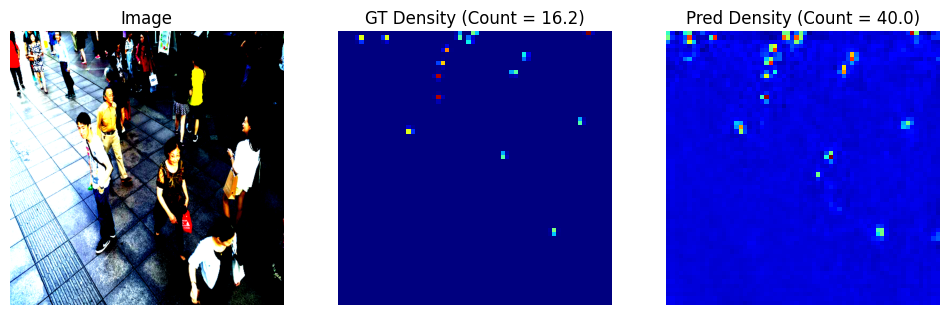

In [37]:
#visualize prediction vs ground truth
import matplotlib.pyplot as plt

def visualize_prediction(sample_idx=0):
    img, gt = val_dataset[sample_idx]
    img_in = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_in).cpu().numpy()[0, 0]

    gt = gt.numpy()[0]
    img = img.permute(1, 2, 0).numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(gt, cmap='jet')
    plt.title(f"GT Density (Count = {gt.sum():.1f})")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='jet')
    plt.title(f"Pred Density (Count = {pred.sum():.1f})")
    plt.axis('off')

visualize_prediction(0)